In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import KFold
from IPython.display import HTML, display
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_boston

In [ ]:
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 20

In [12]:
train = pd.read_csv('C:/bharath/DS/train.csv')
test = pd.read_csv('C:/bharath/DS/train.csv')

In [42]:
train.size

7084

In [16]:
quantitative = [f for f in train.columns if train.dtypes[f]!= 'object']

In [17]:
print(quantitative)

['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']


In [18]:
quantitative.remove('MEDV')
qualitative = [f for f in train.columns if train.dtypes[f] == 'object']
print(qualitative)

[]


In [20]:
missing =  train.isnull().sum()
missing = missing[missing>0]

In [22]:
missing

CRIM     20
ZN       20
INDUS    20
CHAS     20
AGE      20
LSTAT    20
dtype: int64

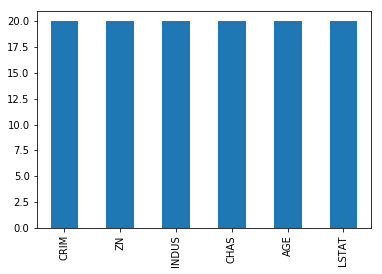

In [21]:
missing.sort_values(inplace = True)
missing.plot.bar()

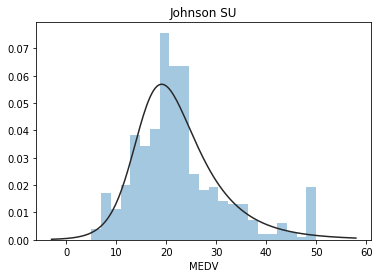

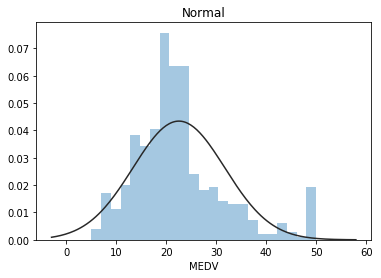

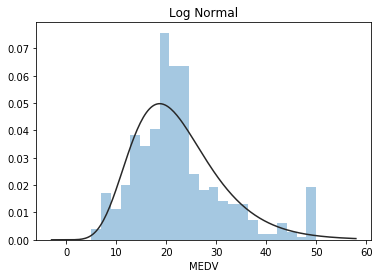

In [26]:
import scipy.stats as st
y = train['MEDV']
plt.figure(1)
plt.title('Johnson SU')
sns.distplot(y,kde = False, fit = st.johnsonsu)
plt.figure(2)
plt.title('Normal')
sns.distplot(y,kde = False, fit = st.norm)
plt.figure(3)
plt.title('Log Normal')
sns.distplot(y,kde = False,fit = st.lognorm)

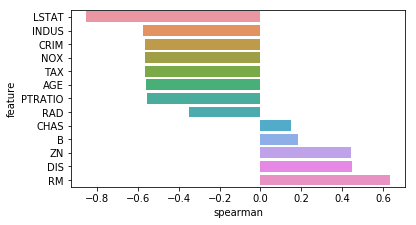

In [28]:
def spearman(frame, features):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame['MEDV'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')
    
features = quantitative 
spearman(train, features)

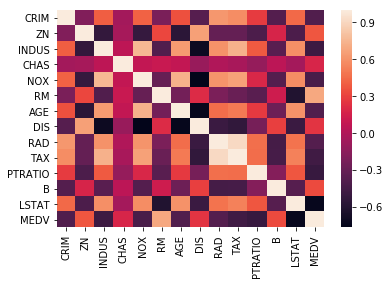

In [29]:
plt.figure(1)
corr = train[quantitative+['MEDV']].corr()
sns.heatmap(corr)

C:\Users\bhara\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


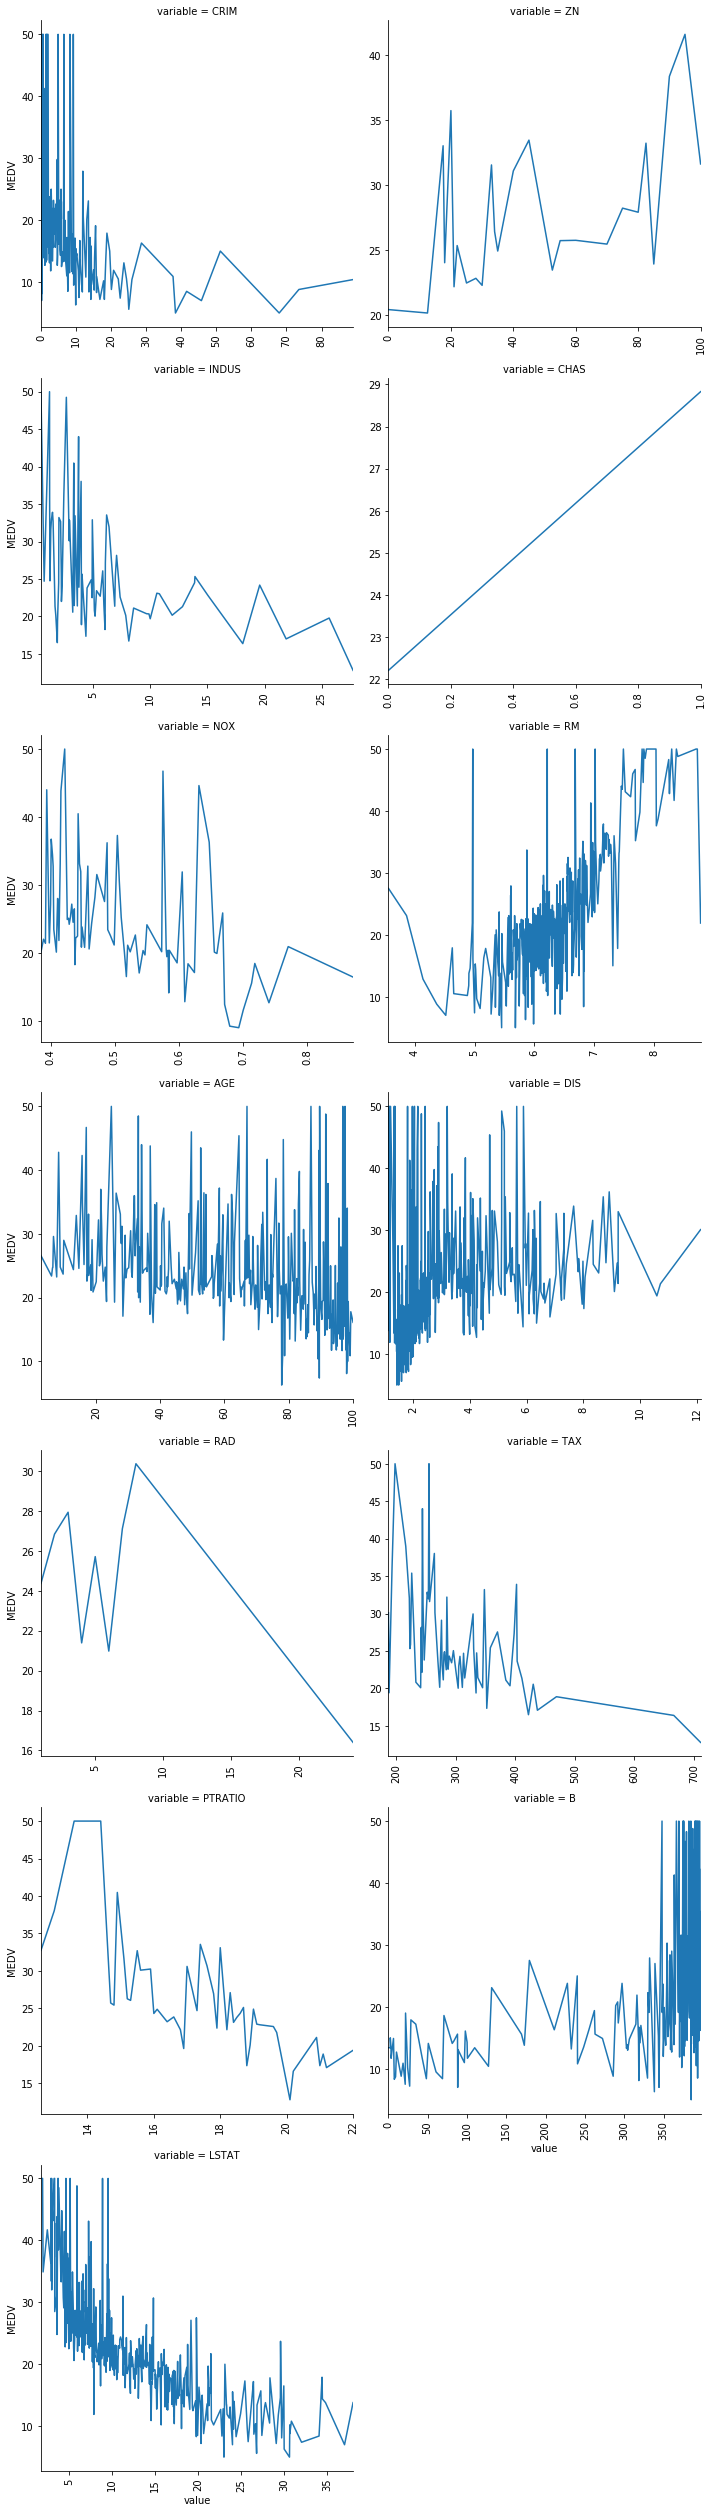

In [30]:
def pairplot(x, y, **kwargs):
    ax = plt.gca()
    ts = pd.DataFrame({'time': x, 'val': y})
    ts = ts.groupby('time').mean()
    ts.plot(ax=ax)
    plt.xticks(rotation=90)
    
f = pd.melt(train, id_vars=['MEDV'], value_vars=quantitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(pairplot, "value", "MEDV")

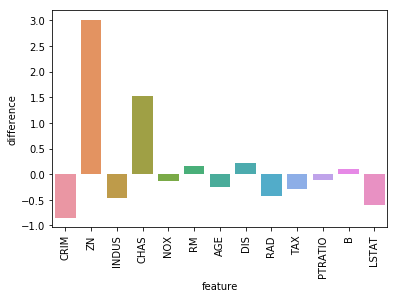

In [31]:
features = quantitative

standard = train[train['MEDV'] < 25]
pricey = train[train['MEDV'] >= 25]

diff = pd.DataFrame()
diff['feature'] = features
diff['difference'] = [(pricey[f].fillna(0.).mean() - standard[f].fillna(0.).mean())/(standard[f].fillna(0.).mean())
                      for f in features]

sns.barplot(data=diff, x='feature', y='difference')
x=plt.xticks(rotation=90)

1.0


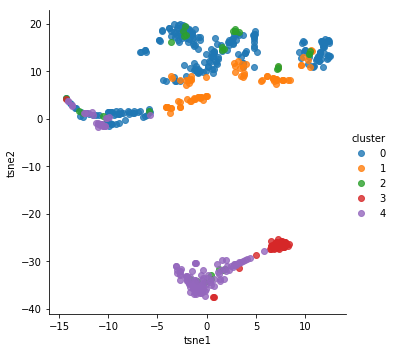

In [35]:
features = quantitative
model = TSNE(n_components=2, random_state=0, perplexity=50)
X = train[features].fillna(0.).values
tsne = model.fit_transform(X)

std = StandardScaler()
s = std.fit_transform(X)
pca = PCA(n_components=13)
pca.fit(s)
pc = pca.transform(s)
kmeans = KMeans(n_clusters=5)
kmeans.fit(pc)

fr = pd.DataFrame({'tsne1': tsne[:,0], 'tsne2': tsne[:, 1], 'cluster': kmeans.labels_})
sns.lmplot(data=fr, x='tsne1', y='tsne2', hue='cluster', fit_reg=False)
print(np.sum(pca.explained_variance_ratio_))

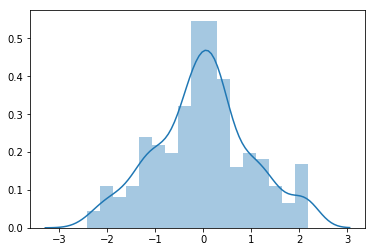

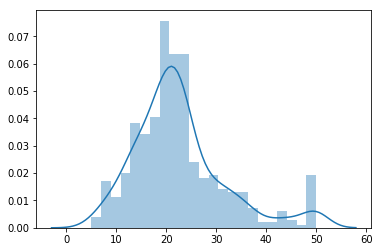

In [36]:
y = train['MEDV'].values
def johnson(y):
    gamma, eta, epsilon, lbda = stats.johnsonsu.fit(y)
    yt = gamma + eta*np.arcsinh((y-epsilon)/lbda)
    return yt, gamma, eta, epsilon, lbda

def johnson_inverse(y, gamma, eta, epsilon, lbda):
    return lbda*np.sinh((y-gamma)/eta) + epsilon

yt, g, et, ep, l = johnson(y)
yt2 = johnson_inverse(yt, g, et, ep, l)
plt.figure(1)
sns.distplot(yt)
plt.figure(2)
sns.distplot(yt2)

In [37]:
def error(actual, predicted):
    actual = np.log(actual)
    predicted = np.log(predicted)
    return np.sqrt(np.sum(np.square(actual-predicted))/len(actual))

features = quantitative
lasso = linear_model.LassoLarsCV(max_iter=10000)
X = train[features].fillna(0.).values
Y = train['MEDV'].values
lasso.fit(X, np.log(Y))

Ypred = np.exp(lasso.predict(X))
error(Y, Ypred)

C:\Users\bhara\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.20089480501911727

In [41]:
import patsy

Y, X = patsy.dmatrices(
   "MEDV ~ \
        CRIM + \
        ZN + \
        INDUS + \
        CHAS + \
        NOX + \
        RM + \
        AGE + \
        DIS + \
        RAD + \
        TAX + \
        PTRATIO + \
        B + \
        LSTAT" ,
    train.to_dict('list'))

ridge = linear_model.RidgeCV(cv=10)
ridge.fit(X, np.log(Y))
Ypred = np.exp(ridge.predict(X))
print(error(Y,Ypred))

0.18107035196486357


C:\Users\bhara\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
